In [1]:
%load_ext autoreload
import json
import sys
import pathlib
from matplotlib import pylab as plt
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns

cp_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/corona_pandemie').rglob('*.ipynb'):
    with open(file) as f:
        cp_data[file.stem.removeprefix('corona_pandemie_')] = json.load(f)

cw_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/corona_warn_app_analyse').rglob('*.ipynb'):
    with open(file) as f:
        cw_data[file.stem.removeprefix('corona_warn_app_analyse_')] = json.load(f)

rp_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/reproduktionszahl').rglob('*.ipynb'):
    with open(file) as f:
        rp_data[file.stem.removeprefix('reproduktionszahl_')] = json.load(f)

wr_data: dict[str, dict] = {}
for file in pathlib.Path('data/shared-dataset/werbeindustrie').rglob('*.ipynb'):
    with open(file) as f:
        wr_data[file.stem.removeprefix('werbeindustrie_')] = json.load(f)

In [2]:
cp_data.keys()

dict_keys(['066e', '146f', '1953', '21de', '2281', '23a6', '3669', '44bd', '4c2a', '4c41', '4ca2', '63e1', '6b4e', '6c5b', '6f62', '7cc7', '88a6', '8ac3', '8c43', '8d45', '8eaf', '9eb2', 'a044', 'abd2', 'ad47', 'b14b', 'b56b', 'baa4', 'c926', 'c938', 'cb76', 'd28c', 'eac9', 'fb4b', 'fe28'])

In [3]:
def filter_images(data):
    """Sets the image data to None in the output of code cells."""
    for k, v in data.items():
        for cell in v['cells']:
            if cell['cell_type'] == 'code' and 'outputs' in cell:
                for output in cell['outputs']:
                    if 'data' in output and 'image/png' in output['data']:
                        # remove image from data
                        output['data']['image/png'] = None

filter_images(cp_data)
filter_images(cw_data)
filter_images(rp_data)
filter_images(wr_data)

In [4]:
from transformers import AutoTokenizer
import os
from dotenv import load_dotenv

load_dotenv()
HUGGINGFACE = os.getenv("HUGGINGFACE")

def calc_tokens(text: str, max_length: int = 0) -> int:
    tokenizer = AutoTokenizer.from_pretrained(
        #"deepseek-ai/DeepSeek-R1",
        "meta-llama/Llama-3.3-70B-Instruct",
        token=HUGGINGFACE)

    tokens = []
    if max_length != 0 and len(text) > max_length:
        for t in [text[i:i + max_length] for i in range(0, len(text), max_length)]:
            tokens.extend(tokenizer.encode(t, add_special_tokens=False))
    else:
        tokens.extend(tokenizer.encode(text, add_special_tokens=False))  # add_special_tokens=True, falls du Sondertokens (z.B. BOS/EOS) berücksichtigen möchtest

    return len(tokens)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [5]:
tokens = {}

for k, v in cp_data.items():
    tokens[f"cp_{k}"] = calc_tokens(str(v))

for k, v in cw_data.items():
    tokens[f"cw_{k}"] = calc_tokens(str(v))

for k, v in rp_data.items():
    tokens[f"rp_{k}"] = calc_tokens(str(v))

for k, v in wr_data.items():
    tokens[f"wr_{k}"] = calc_tokens(str(v))

print(f"Avg. token per notebook: {sum(tokens.values()) / len(tokens)}")

print(f"Avg. token / notebook (cp): {sum([v for k, v in tokens.items() if k.startswith('cp')]) / len([v for k, v in tokens.items() if k.startswith('cp')])}")
print(f"Avg. token / notebook (cw): {sum([v for k, v in tokens.items() if k.startswith('cw')]) / len([v for k, v in tokens.items() if k.startswith('cw')])}")
print(f"Avg. token / notebook (rp): {sum([v for k, v in tokens.items() if k.startswith('rp')]) / len([v for k, v in tokens.items() if k.startswith('rp')])}")
print(f"Avg. token / notebook (wr): {sum([v for k, v in tokens.items() if k.startswith('wr')]) / len([v for k, v in tokens.items() if k.startswith('wr')])}")

Avg. token per notebook: 4378.15
Avg. token / notebook (cp): 8613.085714285715
Avg. token / notebook (cw): 3982.2
Avg. token / notebook (rp): 3941.1714285714284
Avg. token / notebook (wr): 976.1428571428571


In [6]:
cp_data['4c41']

{'cells': [{'cell_type': 'markdown',
   'metadata': {},
   'source': ['### Aufgabe: Corona-Pandemie\n',
    '\n',
    '\n',
    'Im Frühjahr 2020 begann sich das neuartiges Coronavirus SARS-CoV-2, welches die Lungenerkrankung Covid-19 verursachen kann, in Deutschland und Europa schlagartig zu verbreiten. In dieser Aufgabe analysieren und visualisieren Sie das Infektionsgeschehen in Deutschland.\n',
    '\n',
    '**Ihre Daten**\n',
    '\n',
    'Ein vereinfachter Datensatz des Robert Koch Instituts (RKI) steht Ihnen in dieser Aufgabe zur Verfügung.\n',
    '\n',
    '**Ihre Aufgaben**\n',
    '\n',
    '(1) Führen Sie zunächst die unten stehende Code-Zelle aus, um den Datensatz und die Pandas-Bibliothek verfügbar zu machen.\n']},
  {'cell_type': 'code',
   'execution_count': 2,
   'metadata': {},
   'outputs': [],
   'source': ['import pandas as pd\n',
    '\n',
    '# Daten des Robert Koch Instituts\n',
    "RKI_data_simplified = 'http://lab.bialonski.de/data/ds/kUdBuPrXjvr5d640Ey3UN

In [6]:
%autoreload 2
from llm import send_prompt, sort_function

def sort_f1(d1, d2):
    systemprompt = """You are given two Jupyter notebooks (Notebook A and Notebook B), each containing exercises and solutions. Determine which notebook contains the better solutions. A good solution should be correct, accurate and complete. Which notebook is the better one? Output ONLY "Notebook A" or "Notebook B"."""

    return sort_function(d1, d2, rp_data, systemprompt)

sort_f1('4c41', 'fb4b')

4c41 > fb4b


False

In [118]:
cp_data.keys()

dict_keys(['066e', '146f', '1953', '21de', '2281', '23a6', '3669', '44bd', '4c2a', '4c41', '4ca2', '63e1', '6b4e', '6c5b', '6f62', '7cc7', '88a6', '8ac3', '8c43', '8d45', '8eaf', '9eb2', 'a044', 'abd2', 'ad47', 'b14b', 'b56b', 'baa4', 'c926', 'c938', 'cb76', 'd28c', 'eac9', 'fb4b', 'fe28'])

In [8]:
%autoreload 2
from sort import quicksort, heapsort
import random

check_idxs = list(rp_data.keys())
random.shuffle(check_idxs)

rp_data_sorted = heapsort(check_idxs, sort_f1)

146f > 4ca2
146f < 8eaf
2281 < 4c41
4c41 > eac9
23a6 > c926
23a6 > 6f62
c938 > 63e1
c938 > 066e
7cc7 > abd2
7cc7 > 8ac3
21de < 6b4e
6b4e > 8c43
1953 > fb4b
1953 < 88a6
cb76 < fe28
fe28 > 4c2a
8d45 > b14b
8d45 > 3669
4c41 > 8eaf
2281 < eac9
eac9 > baa4
c938 > 23a6
066e < 63e1
63e1 < d28c
c938 < d28c
6b4e > 7cc7
21de < 8c43
8c43 > 44bd
fe28 > 88a6
cb76 > 4c2a
Rate limit hit. Retrying in 4 seconds... (Attempt 1/10)
cb76 > b56b
4c41 > 8d45
eac9 > 8eaf
2281 > baa4
2281 > 9eb2
6b4e < d28c
c938 > 23a6
066e < 63e1
63e1 > ad47
4c41 > fe28
eac9 > 8d45
2281 > 8eaf
9eb2 < baa4
baa4 > a044
4c41 > d28c
eac9 > fe28
2281 > 8d45
baa4 > 8eaf
9eb2 < a044
a044 > 6c5b
eac9 > d28c
2281 < fe28
cb76 > 88a6
b56b < 4c2a
4c2a > 4ca2
fe28 > d28c
2281 > cb76
baa4 < 8d45
3669 > b14b
3669 > 146f
Rate limit hit. Retrying in 10 seconds... (Attempt 1/10)
2281 < d28c
6b4e > c938
8c43 < 7cc7
8ac3 < abd2
abd2 > 6c5b
2281 > 6b4e
8d45 > cb76
baa4 < 3669
146f < b14b
b14b > 9eb2
8d45 > 6b4e
3669 > cb76
baa4 < b14b
146f > 9eb2

In [9]:
rp_data_sorted

['fb4b',
 'b56b',
 '9eb2',
 '4ca2',
 '066e',
 '8ac3',
 'ad47',
 '146f',
 '21de',
 '63e1',
 '1953',
 '4c2a',
 '8eaf',
 '23a6',
 'c938',
 'abd2',
 '44bd',
 '8c43',
 'c926',
 '6f62',
 '6c5b',
 'a044',
 '7cc7',
 'baa4',
 '6b4e',
 '88a6',
 'cb76',
 'b14b',
 '3669',
 '8d45',
 '2281',
 'd28c',
 'fe28',
 'eac9',
 '4c41']

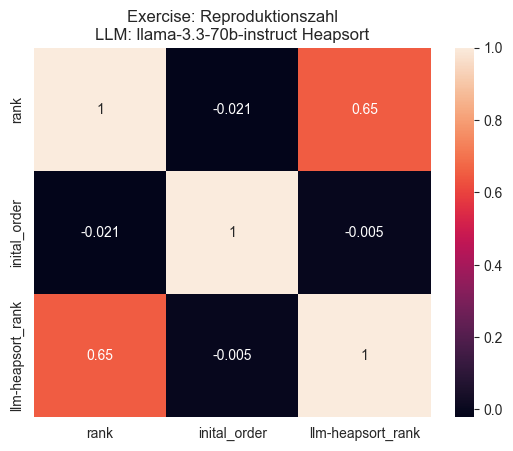

In [17]:
reproduktionszahl_points = pd.read_csv('data/shared-dataset/reproduktionszahl_points.csv')

df = reproduktionszahl_points.loc[:, ['id', 'rank']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: rp_data_sorted[::-1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Reproduktionszahl\nLLM: llama-3.3-70b-instruct Heapsort")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [18]:
df

,rank,inital_order,llm-heapsort_rank
id,,,
4c41,1,32,0
fe28,2,20,2
44bd,3,5,18
eac9,4,15,1
3669,5,8,6
d28c,6,6,3
8d45,7,17,5
cb76,8,19,8
6b4e,9,24,10


In [27]:
from copy import deepcopy

def filter_output_cells(data_array):
    """Removes the output of code cells."""
    data = deepcopy(data_array)
    for k, v in data.items():
        for i, cell in enumerate(v['cells']):
            if cell['cell_type'] == 'code' and 'outputs' in cell:
                #print(cell['outputs'])
                data[k]['cells'][i]['outputs'] = []
    return data


rp_data_filtered = filter_output_cells(rp_data)

In [28]:
%autoreload 2
from llm import send_prompt, sort_function

def sort_f2(d1, d2):
    systemprompt = """You are given two Jupyter notebooks (Notebook A and Notebook B), each containing exercises and solutions. Determine which notebook contains the better solutions. A good solution should be correct, accurate and complete. Which notebook is the better one? Output ONLY "Notebook A" or "Notebook B"."""

    return sort_function(d1, d2, rp_data_filtered, systemprompt)

In [29]:
initial_ordering = list(rp_data_filtered.keys())
random.shuffle(initial_ordering)

rp_data_filtered_sorted = heapsort(initial_ordering, sort_f2)

44bd > 1953
44bd > 6c5b
a044 < 7cc7
7cc7 < 4c41
8eaf > 9eb2
8eaf < 6b4e
b14b < eac9
eac9 > 23a6
fe28 > 8d45
fe28 > 146f
21de < 2281
2281 > baa4
ad47 < 4c2a
4c2a > b56b
4ca2 > fb4b
4ca2 > 066e
88a6 < 3669
3669 > abd2
4c41 > 44bd
a044 < 7cc7
7cc7 > 6f62
eac9 > 6b4e
b14b > 23a6
b14b < d28c
eac9 > d28c
2281 < fe28
146f < 8d45
8d45 > c926
4ca2 < 4c2a
ad47 > b56b
Rate limit hit. Retrying in 18 seconds... (Attempt 1/10)
ad47 < 8c43
4c2a < 8c43
4c41 > 3669
7cc7 < 44bd
6c5b < 1953
1953 < cb76
44bd < cb76
4c41 > cb76
fe28 > eac9
2281 < 8d45
146f < c926
c926 > c938
4c41 > 8c43
cb76 < 3669
88a6 > abd2
88a6 > 8ac3
4c41 > fe28
3669 > 8c43
cb76 > 88a6
7cc7 < 44bd
6c5b < 1953
1953 > 63e1
3669 > fe28
cb76 > 8c43
44bd < 88a6
8ac3 < abd2
abd2 > 63e1
cb76 < fe28
8d45 < eac9
d28c > 6b4e
Rate limit hit. Retrying in 33 seconds... (Attempt 1/10)
b14b > 23a6
b14b > 6c5b
cb76 < eac9
8d45 < d28c
b14b > 6b4e
6c5b < 23a6
23a6 > 6f62
cb76 > d28c
88a6 > 8c43
44bd > abd2
7cc7 > 1953
7cc7 > a044
88a6 < d28c
8d45 > b14

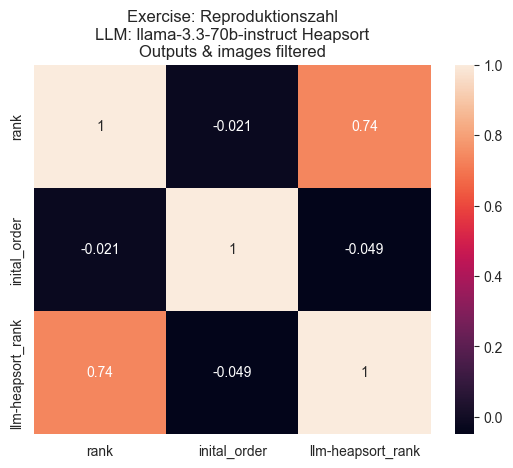

In [30]:
df = reproduktionszahl_points.loc[:, ['id', 'rank']]

df['inital_order'] = df['id'].map(lambda x: check_idxs.index(x))
df['llm-heapsort_rank'] = df['id'].map(lambda x: rp_data_filtered_sorted[::-1].index(x))
df.set_index('id', inplace=True)

plt.title("Exercise: Reproduktionszahl\nLLM: llama-3.3-70b-instruct Heapsort\nOutputs & images filtered")
sns.heatmap(df.corr(method='kendall'), annot=True)
plt.show()

In [40]:
# convert jupyter notebook to markdown
import nbformat
from nbconvert import MarkdownExporter

def nb_to_md(nb):
    exporter = MarkdownExporter()
    markdown, _ = exporter.from_notebook_node(nbformat.from_dict(nb))
    return markdown

nb_to_md(nbformat.read('data/shared-dataset/corona_pandemie/corona_pandemie_4c41.ipynb', as_version=4))

'### Aufgabe: Corona-Pandemie\n\n\nIm Frühjahr 2020 begann sich das neuartiges Coronavirus SARS-CoV-2, welches die Lungenerkrankung Covid-19 verursachen kann, in Deutschland und Europa schlagartig zu verbreiten. In dieser Aufgabe analysieren und visualisieren Sie das Infektionsgeschehen in Deutschland.\n\n**Ihre Daten**\n\nEin vereinfachter Datensatz des Robert Koch Instituts (RKI) steht Ihnen in dieser Aufgabe zur Verfügung.\n\n**Ihre Aufgaben**\n\n(1) Führen Sie zunächst die unten stehende Code-Zelle aus, um den Datensatz und die Pandas-Bibliothek verfügbar zu machen.\n\n\n\n```python\nimport pandas as pd\n\n# Daten des Robert Koch Instituts\nRKI_data_simplified = \'http://lab.bialonski.de/data/ds/kUdBuPrXjvr5d640Ey3UN82VKz646KLj2tuZFTFZ.csv\'\n```\n\n(2) Importieren Sie mithilfe von Pandas den Datensatz in einen DataFrame, den Sie `df_covid` nennen. Nutzen Sie dazu die Variable `RKI_data_simplified`.\n\n\n\n```python\n# Ihr Code\n\ndf = pd.read_csv(RKI_data_simplified)\ndf.head()\n`

In [41]:
nbformat.read('data/shared-dataset/corona_pandemie/corona_pandemie_4c41.ipynb', as_version=4)

{'cells': [{'cell_type': 'markdown',
   'metadata': {},
   'source': '### Aufgabe: Corona-Pandemie\n\n\nIm Frühjahr 2020 begann sich das neuartiges Coronavirus SARS-CoV-2, welches die Lungenerkrankung Covid-19 verursachen kann, in Deutschland und Europa schlagartig zu verbreiten. In dieser Aufgabe analysieren und visualisieren Sie das Infektionsgeschehen in Deutschland.\n\n**Ihre Daten**\n\nEin vereinfachter Datensatz des Robert Koch Instituts (RKI) steht Ihnen in dieser Aufgabe zur Verfügung.\n\n**Ihre Aufgaben**\n\n(1) Führen Sie zunächst die unten stehende Code-Zelle aus, um den Datensatz und die Pandas-Bibliothek verfügbar zu machen.\n'},
  {'cell_type': 'code',
   'execution_count': 2,
   'metadata': {},
   'outputs': [],
   'source': "import pandas as pd\n\n# Daten des Robert Koch Instituts\nRKI_data_simplified = 'http://lab.bialonski.de/data/ds/kUdBuPrXjvr5d640Ey3UN82VKz646KLj2tuZFTFZ.csv'"},
  {'cell_type': 'markdown',
   'metadata': {},
   'source': '(2) Importieren Sie mithil

In [44]:
rp_data['88a6']

{'cells': [{'cell_type': 'markdown',
   'metadata': {},
   'source': ['### Aufgabe: Reproduktionszahl\n',
    '\n',
    '\n',
    'Sie bestimmen in dieser Aufgabe die Reproduktionszahl $R_0$ für die Covid-19 Pandemie in Deutschland anhand der Daten des Robert-Koch-Instituts. Die Reproduktionszahl $R_0$ gibt an, wie viele Menschen von einer infektiösen Person durchschnittlich angesteckt werden, wenn kein Mitglied der Population gegenüber dem Erreger immun ist.\n',
    '\n',
    'Sie werden eine vereinfachte Schätzung der $R_0$-Zahl durchführen. Die $R_0$-Zahl eines Tages $t$ sei definiert als\n',
    '\n',
    '$$ R_0(t) := \\frac{\\sum_{x = t-3}^t I_x }{\\sum_{x = t-7}^{t-4} I_x},$$\n',
    '\n',
    'wobei $I_x$ die Anzahl der Neuinfizierten eines Tages $x$ bezeichnet.\n',
    '\n',
    'Die $R_0$-Zahl entspricht also der Summe der Infizierten innerhalb eines 4-Tageszeitraums dividiert durch die Summe der Infizierten des davorliegenden 4-Tageszeitraums.\n',
    '\n',
    '**Ihre Daten